<img src="https://github.com/rjpost20/Anomalous-Bank-Transactions-Detection-Project/blob/main/data/AdobeStock_319163865.jpeg?raw=true">
Image by <a href="https://stock.adobe.com/contributor/200768506/andsus?load_type=author&prev_url=detail" >AndSus</a> on Adobe Stock

# Phase 5 Project: *Detecting Anomalous Financial Transactions*

## Notebook 4: Modeling Part 2, Results, Analysis and Inferences

### By Ryan Posternak

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 25th, 2022<br>
Instructor: Joseph Mata

<br>

# Imports and Reading in Data

### Google colab compatibility downloads

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz 
!tar xf spark-3.3.0-bin-hadoop3.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
!pip install pyspark==3.3.0
!pip install -q findspark
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [910 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/main amd64 

In [2]:
# Connect to Google drive
from google.colab import drive, files
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, \
MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, TrainValidationSplitModel

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
plt.style.use('seaborn')
from IPython.display import HTML, display
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
# Import helper functions
helper_functions = files.upload()
from helper_functions import set_weight_col, spark_resample, grid_search, score_model, plot_confusion_matrix

Saving helper_functions.py to helper_functions.py


In [5]:
# Check Colab RAM info
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
# Set text to wrap in Google colab notebook
def set_css():
    display(HTML("""
    <style>
      pre {
          white-space: pre-wrap;
      }
    </style>
    """))
get_ipython().events.register('pre_run_cell', set_css)

In [7]:
# Initialize Spark Session
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config("spark.ui.port", "4050")\
        .config("spark.driver.memory", "15g")\
        .getOrCreate()

spark

## Read in Data

In [8]:
# Read in train_df_full and test_df_full data csv files as Spark DataFrames
train_df_full = spark.read.csv(drive_path + 'train_df_full.csv', header=True, inferSchema=True)
test_df_full = spark.read.csv(drive_path + 'test_df_full.csv', header=True, inferSchema=True)

<br>

## Add `Weight` column to dataframe

As we've seen, the training dataset is extremely imbalanced in regards to target class distribution. In order to improve modeling performance, we'll add a new column `Weight` to `train_df_full` specifying the weights to use, which we pass in to PySpark models in the `weightCol` parameter. We'll create the new `Weight` column using the `set_weight_col` function in `helper_functions`.

Our initial `Weight` column will specify equal weights across all observations, which is the default in PySpark.

In [9]:
print(set_weight_col.__doc__)


    Calculates and creates a column of class weights 
    in a PySpark dataframe with an imbalanced binary 
    target class distribution.

    Parameters
    ----------
    df : Spark `DataFrame`
        The Spark `DataFrame` to assign the 
        `ClassWeight` column to
    label_col : Spark `Column`
        Label column name
    pos_class_weight : `float` or 'balanced'
        Class weight to assign to positive class 
        (`1`) in weight column. If 'balanced', assigned 
        class weights will be equal to 1 - proportion of 
        class in dataframe. If `float`, positive class 
        will be assigned `pos_class_weight`.
    neg_class_weight : '`float` or 'balanced'
        Class weight to assign to negative class 
        (`0`) in weight column. If 'balanced', assigned 
        class weights will be equal to 1 - proportion of 
        class in dataframe. If `float`, negative class 
        will be assigned `neg_class_weight`.
    


In [10]:
train_df_full = set_weight_col(train_df_full, label_col='Label', pos_class_weight=1.0, neg_class_weight=1.0)

In [11]:
# Preview Weight column
cols_to_show = ['MessageId', 'Label', 'Weight']
train_df_full.select(cols_to_show).where(train_df_full.Label == 0).show(1, truncate=False, vertical=True)
train_df_full.select(cols_to_show).where(train_df_full.Label == 1).show(1, truncate=False, vertical=True)

-RECORD 0---------------
 MessageId | TRFXV1O7R2 
 Label     | 0          
 Weight    | 1.0        
only showing top 1 row

-RECORD 0---------------
 MessageId | TR14I40JIT 
 Label     | 1          
 Weight    | 1.0        
only showing top 1 row



In [12]:
# Print shape of dataframes
print(f"train_df_full:  {train_df_full.count():,} Rows, {len(train_df_full.columns)} Columns")
print(f"test_df_full:  {test_df_full.count():,} Rows, {len(test_df_full.columns)} Columns")

train_df_full:  4,691,725 Rows, 21 Columns
test_df_full:  705,108 Rows, 20 Columns


In [13]:
# Print schema of training dataframe
print('train_df_full:')
train_df_full.printSchema()

train_df_full:
root
 |-- MessageId: string (nullable = true)
 |-- SettlementCurrency: string (nullable = true)
 |-- InstructedCurrency: string (nullable = true)
 |-- Label: integer (nullable = true)
 |-- OrderingCountry: string (nullable = true)
 |-- BeneficiaryCountry: string (nullable = true)
 |-- InstructedAmountUSD: integer (nullable = true)
 |-- IntermediaryTransactions: integer (nullable = true)
 |-- OriginalSender: string (nullable = true)
 |-- FinalReceiver: string (nullable = true)
 |-- Flagged: integer (nullable = true)
 |-- OrderingCountryFreq: integer (nullable = true)
 |-- BeneficiaryCountryFreq: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- SenderHourFreq: integer (nullable = true)
 |-- SenderCurrencyFreq: integer (nullable = true)
 |-- SenderCurrencyAmtAvg: integer (nullable = true)
 |-- SenderFreq: integer (nullable = true)
 |-- ReceiverFreq: integer (nullable = true)
 |-- SenderReceiverFreq: integer (nullable = true)
 |-- Weight: double (nullable 

In [14]:
# Print schema of test dataframe
print('test_df_full:')
test_df_full.printSchema()

test_df_full:
root
 |-- MessageId: string (nullable = true)
 |-- SettlementCurrency: string (nullable = true)
 |-- InstructedCurrency: string (nullable = true)
 |-- Label: integer (nullable = true)
 |-- OrderingCountry: string (nullable = true)
 |-- BeneficiaryCountry: string (nullable = true)
 |-- InstructedAmountUSD: integer (nullable = true)
 |-- IntermediaryTransactions: integer (nullable = true)
 |-- OriginalSender: string (nullable = true)
 |-- FinalReceiver: string (nullable = true)
 |-- Flagged: integer (nullable = true)
 |-- OrderingCountryFreq: integer (nullable = true)
 |-- BeneficiaryCountryFreq: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- SenderHourFreq: integer (nullable = true)
 |-- SenderCurrencyFreq: integer (nullable = true)
 |-- SenderCurrencyAmtAvg: integer (nullable = true)
 |-- SenderFreq: integer (nullable = true)
 |-- ReceiverFreq: integer (nullable = true)
 |-- SenderReceiverFreq: integer (nullable = true)



In [15]:
# Drop 'MessageId' individual transaction identifier column - will not be used in modeling
train_df_full = train_df_full.drop('MessageId')
test_df_full = test_df_full.drop('MessageId')

# Rename target variable 'Label' column to more descriptive 'Anomalous'
train_df_full = train_df_full.withColumnRenamed('Label', 'Anomalous')
test_df_full = test_df_full.withColumnRenamed('Label', 'Anomalous')

In [16]:
# Display first row of train_df_full dataframe
train_df_full.show(n=1, truncate=False, vertical=True)

-RECORD 0----------------------------
 SettlementCurrency       | EUR      
 InstructedCurrency       | EUR      
 Anomalous                | 0        
 OrderingCountry          | PE       
 BeneficiaryCountry       | EC       
 InstructedAmountUSD      | 519149   
 IntermediaryTransactions | 0        
 OriginalSender           | FAMAPEPL 
 FinalReceiver            | KNPVECEQ 
 Flagged                  | 0        
 OrderingCountryFreq      | 73733    
 BeneficiaryCountryFreq   | 40984    
 Hour                     | 8        
 SenderHourFreq           | 47559    
 SenderCurrencyFreq       | 73733    
 SenderCurrencyAmtAvg     | 1906631  
 SenderFreq               | 73733    
 ReceiverFreq             | 41012    
 SenderReceiverFreq       | 40984    
 Weight                   | 1.0      
only showing top 1 row



In [17]:
# Display first row of test_df_full dataframe
test_df_full.show(n=1, truncate=False, vertical=True)

-RECORD 0----------------------------
 SettlementCurrency       | EUR      
 InstructedCurrency       | EUR      
 Anomalous                | 0        
 OrderingCountry          | PE       
 BeneficiaryCountry       | EC       
 InstructedAmountUSD      | 653958   
 IntermediaryTransactions | 0        
 OriginalSender           | FAMAPEPL 
 FinalReceiver            | KNPVECEQ 
 Flagged                  | 0        
 OrderingCountryFreq      | 73733    
 BeneficiaryCountryFreq   | 40984    
 Hour                     | 8        
 SenderHourFreq           | 47559    
 SenderCurrencyFreq       | 73733    
 SenderCurrencyAmtAvg     | 1906631  
 SenderFreq               | 73733    
 ReceiverFreq             | 41012    
 SenderReceiverFreq       | 40984    
only showing top 1 row



In [18]:
# Display value counts for 'Anomalous' column (classification target)
class_counts = train_df_full.groupBy('Anomalous').count().withColumn('percent', F.col('count')/train_df_full.count())

class_counts.show(truncate=False)

+---------+-------+---------------------+
|Anomalous|count  |percent              |
+---------+-------+---------------------+
|1        |4900   |0.0010443919880214632|
|0        |4686825|0.9989556080119786   |
+---------+-------+---------------------+



<br>

# Create `Pipeline` to Preprocess and Model `train_df_full` Data

### Index string columns with `StringIndexer`

In [19]:
stages = []

categoricalCols = [item[0] for item in train_df_full.dtypes if item[1].startswith('string')]

indexers = []
for col in categoricalCols:
    indexer = StringIndexer(inputCol=col, outputCol=col + '_index', handleInvalid='keep')
    indexers.append(indexer)
    
indexed_features = []
for si in indexers:
    indexed_features.append(si.getOutputCol())
    
print(f"Indexed nominal categorical features: {len(indexed_features)}")
print(indexed_features)

Indexed nominal categorical features: 6
['SettlementCurrency_index', 'InstructedCurrency_index', 'OrderingCountry_index', 'BeneficiaryCountry_index', 'OriginalSender_index', 'FinalReceiver_index']


### Create a `OneHotEncoder` to encode the indexed string features

In [20]:
encoder = OneHotEncoder(inputCols=indexed_features, 
                        outputCols=[col + '_ohe' for col in indexed_features], 
                        dropLast=True)

print(f"One hot encoded nominal categorical features: {len(encoder.getOutputCols())}")
print(encoder.getOutputCols())

One hot encoded nominal categorical features: 6
['SettlementCurrency_index_ohe', 'InstructedCurrency_index_ohe', 'OrderingCountry_index_ohe', 'BeneficiaryCountry_index_ohe', 'OriginalSender_index_ohe', 'FinalReceiver_index_ohe']


### Compile numeric features, not including target or class weight columns

In [21]:
numeric_features = []
for column, dtype in train_df_full.dtypes:
    if column != 'Anomalous' and column != 'Weight' and dtype != 'string':
        numeric_features.append(column)

# Confirm equal column counts
assert len(train_df_full.drop('Anomalous', 'Weight').columns) == len(indexed_features) + len(numeric_features)
print(f"Numeric features: {len(numeric_features)}\n{numeric_features}")

Numeric features: 12
['InstructedAmountUSD', 'IntermediaryTransactions', 'Flagged', 'OrderingCountryFreq', 'BeneficiaryCountryFreq', 'Hour', 'SenderHourFreq', 'SenderCurrencyFreq', 'SenderCurrencyAmtAvg', 'SenderFreq', 'ReceiverFreq', 'SenderReceiverFreq']


In [22]:

# Print names of final features going into the model
features = encoder.getOutputCols() + numeric_features
print(f"Final features: \n{features}")

Final features: 
['SettlementCurrency_index_ohe', 'InstructedCurrency_index_ohe', 'OrderingCountry_index_ohe', 'BeneficiaryCountry_index_ohe', 'OriginalSender_index_ohe', 'FinalReceiver_index_ohe', 'InstructedAmountUSD', 'IntermediaryTransactions', 'Flagged', 'OrderingCountryFreq', 'BeneficiaryCountryFreq', 'Hour', 'SenderHourFreq', 'SenderCurrencyFreq', 'SenderCurrencyAmtAvg', 'SenderFreq', 'ReceiverFreq', 'SenderReceiverFreq']


### Create a `VectorAssembler` to combine all features

In [23]:
assembler = VectorAssembler(inputCols=features, outputCol='vectorized_features')

# Assemble a list of stages that includes the vector assembler and standard scaler
scaler = StandardScaler(inputCol='vectorized_features', outputCol='scaled_features')

stages = indexers + [encoder, assembler, scaler]
print("Stages:", stages)

Stages: [StringIndexer_e119d6fbbcf4, StringIndexer_a3933164a529, StringIndexer_f0e539fa03f5, StringIndexer_568d383f1dc6, StringIndexer_160ce51f9205, StringIndexer_763485010873, OneHotEncoder_77451f637b47, VectorAssembler_741b96bcaca0, StandardScaler_0310a8534e59]


### Preview modeling pipeline

In [24]:
pipeline = Pipeline(stages=stages)

pipeline_model = pipeline.fit(train_df_full)

pipeline_df = pipeline_model.transform(train_df_full)

In [25]:
# Display first row of train_df_full after running through pipeline
pipeline_df.show(1, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 SettlementCurrency           | EUR                                                                                                                                                                                                                                                                                                                                                                            
 InstructedCurrency           | EUR                                                                                                                                                                     

In [26]:
pipeline_test = pipeline.fit(test_df_full)

pipeline_df_test = pipeline_model.transform(test_df_full)

pipeline.fit(test_df_full).transform(test_df_full).head()['scaled_features'].size

91

In [27]:
# Display first row of test_df_full after running through pipeline
pipeline_df_test.show(1, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 SettlementCurrency           | EUR                                                                                                                                                                                                                                                                                                                                                                            
 InstructedCurrency           | EUR                                                                                                                                                                     

<br>

# **Model 4.2**: Decision Tree Classifier, Oversampled, with Tuned Max Depth

For our first model on the full training dataset, we'll use the best classifier from notebook-3, which was a `DecisionTreeClassifier`. For the dataset, we are going to use default class weights of 1.0 across all observations, but we're now going to try upsampling the positive class (anomalous transactions) 10x in the dataset. We'll keep the negative class observations as is. We'll use our function `spark_resample` in helper_functions to do the resampling.

In [28]:
print(spark_resample.__doc__)


    Resamples PySpark dataframe with an imbalanced binary 
    target class distribution through a combination of 
    undersampling the majority (negative) class and 
    oversampling the minority (positive) class.

    Parameters
    ----------
    df : Spark `DataFrame`
        The Spark `DataFrame` to resample
    ratio : `float`
        Desired ratio of positive (oversampled) class to 
        negative (undersampled) class in new `DataFrame`
    new_count : `int`
        Desired total count of observations (rows) in new
        `DataFrame`
    oversample_fraction : `float`
        Fraction to oversample minority class
    undersample_fraction : `float`
        Fraction to undersample majority class
    class_field : Spark `Column`
        Name of `Column` in `DataFrame` to resample
    pos_class : `DataType` of `class_field`
        Label of positive class in `class_field`
    shuffle : `bool`
        Whether to shuffle `DataFrame` before returning 
        resampled `DataFrame`.

In [29]:
train_df_full_resampled = spark_resample(df=train_df_full, oversample_fraction=10.0, undersample_fraction=1.0, 
                                         class_field='Anomalous', pos_class=1, shuffle=True, random_state=42)

# Drop Weight column
train_df_full_resampled = train_df_full_resampled.drop('Weight')
# Print shape of resampled dataframe
print(f"train_df_full_resampled:  {train_df_full_resampled.count():,} Rows, {len(train_df_full_resampled.columns)} Columns")
# Display value counts for 'Label' column (classification target) of resampled dataframe
upsampled_class_counts = train_df_full_resampled.groupBy('Anomalous').count()\
                         .withColumn('percent', F.col('count')/train_df_full_resampled.count())

upsampled_class_counts.show(truncate=10)

train_df_full_resampled:  4,736,064 Rows, 19 Columns
+---------+-------+----------+
|Anomalous|  count|   percent|
+---------+-------+----------+
|        0|4686825|0.98960...|
|        1|  49239|0.01039...|
+---------+-------+----------+



In [30]:
dt_1 = DecisionTreeClassifier(
    featuresCol='scaled_features',
    labelCol='Anomalous')

dt_1_stages = stages + [dt_1]

# Specify parameter grid
dt_1_grid = ParamGridBuilder()\
            .addGrid(dt_1.maxDepth, [3, 4, 5, 6])\
            .build()

In [31]:
# Run grid search using grid_search function
if not os.path.isdir(drive_path + 'dt_1_model_full'):
    dt_1_model = grid_search(stages_with_classifier=dt_1_stages, 
                             train_df=train_df_full_resampled, 
                             model_grid=dt_1_grid, 
                             parallelism=4)

In [32]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'dt_1_model_full'):
    dt_1_model.save(drive_path + 'dt_1_model_full')
else:
    dt_1_model = TrainValidationSplitModel.load(drive_path + 'dt_1_model_full')
    print(dt_1_grid[np.argmax(dt_1_model.validationMetrics)])

{Param(parent='DecisionTreeClassifier_277cd5d26974', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 3}


In [33]:
# Print model scores
score_model(dt_1_model, train_df_full_resampled, test_df_full)

DecisionTreeClassificationModel
------------------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.994     1.000     0.997   4686825
    1: Anomalous      1.000     0.406     0.578     49239

        accuracy                          0.994   4736064
       macro avg      0.997     0.703     0.787   4736064
    weighted avg      0.994     0.994     0.993   4736064

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000    704347
    1: Anomalous      1.000     0.384     0.555       761

        accuracy                          0.999    705108
       macro avg      1.000     0.692     0.777    705108
    weighted avg      0.999     0.999     0.999    705108



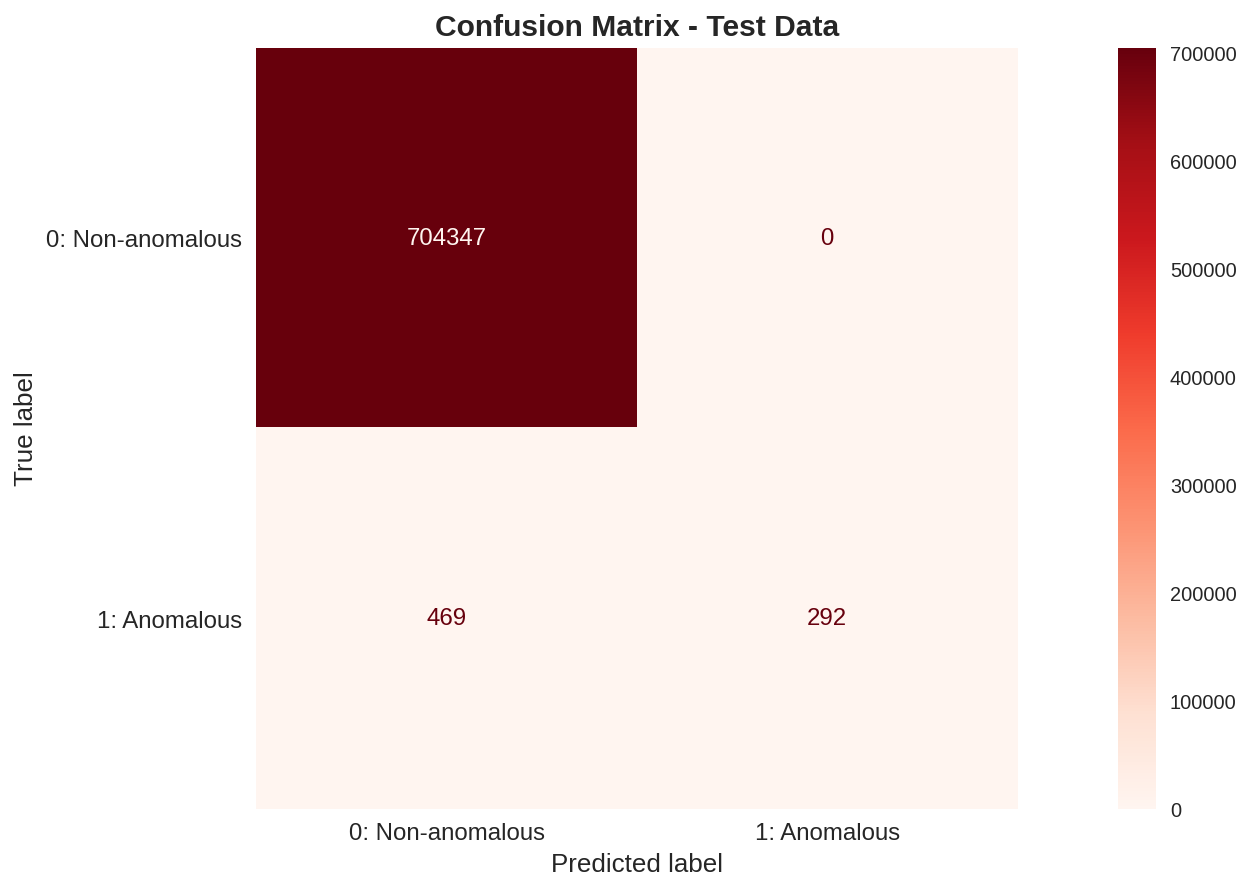

In [34]:
# Plot model confusion matrix
plot_confusion_matrix(dt_1_model, test_df_full)

**Remarks:**
- Interesting, it looks like we matched our best decision tree tree in the previous notebook exactly, even after bringing in all categorical features and upsampling the minority class in the dataset. This will be our benchline for our next models going forward in this notebook.

<br>

# Model 6.1: **Random Forest Classifier**, Oversampled, with Tuned Max Depth and Information Gain Criterion

For our first random forest model, we'll keep the upsampled dataset that we used in the last model, while tuning the max depth of the trees and the information gain criterion (`impurity`).

In [35]:
rf_1 = RandomForestClassifier(
    featuresCol='scaled_features',
    labelCol='Anomalous')

rf_1_stages = stages + [rf_1]

# Specify parameter grid
rf_1_grid = ParamGridBuilder()\
            .addGrid(rf_1.maxDepth, [4, 5, 6, 7])\
            .addGrid(rf_1.impurity, ['gini', 'entropy'])\
            .build()

In [36]:
# Run grid search using grid_search function
if not os.path.isdir(drive_path + 'rf_1_model_full'):
    rf_1_model = grid_search(stages_with_classifier=rf_1_stages, 
                             train_df=train_df_full_resampled, 
                             model_grid=rf_1_grid, 
                             parallelism=5)

In [37]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'rf_1_model_full'):
    rf_1_model.save(drive_path + 'rf_1_model_full')
else:
    rf_1_model = TrainValidationSplitModel.load(drive_path + 'rf_1_model_full')
    print(rf_1_grid[np.argmax(rf_1_model.validationMetrics)])

{Param(parent='RandomForestClassifier_bce1d069b48b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7, Param(parent='RandomForestClassifier_bce1d069b48b', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'entropy'}


In [38]:
# Print model scores
score_model(rf_1_model, train_df_full_resampled, test_df_full)

RandomForestClassificationModel
------------------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.993     1.000     0.996   4686825
    1: Anomalous      1.000     0.312     0.476     49239

        accuracy                          0.993   4736064
       macro avg      0.996     0.656     0.736   4736064
    weighted avg      0.993     0.993     0.991   4736064

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000    704347
    1: Anomalous      1.000     0.322     0.487       761

        accuracy                          0.999    705108
       macro avg      1.000     0.661     0.743    705108
    weighted avg      0.999     0.999     0.999    705108



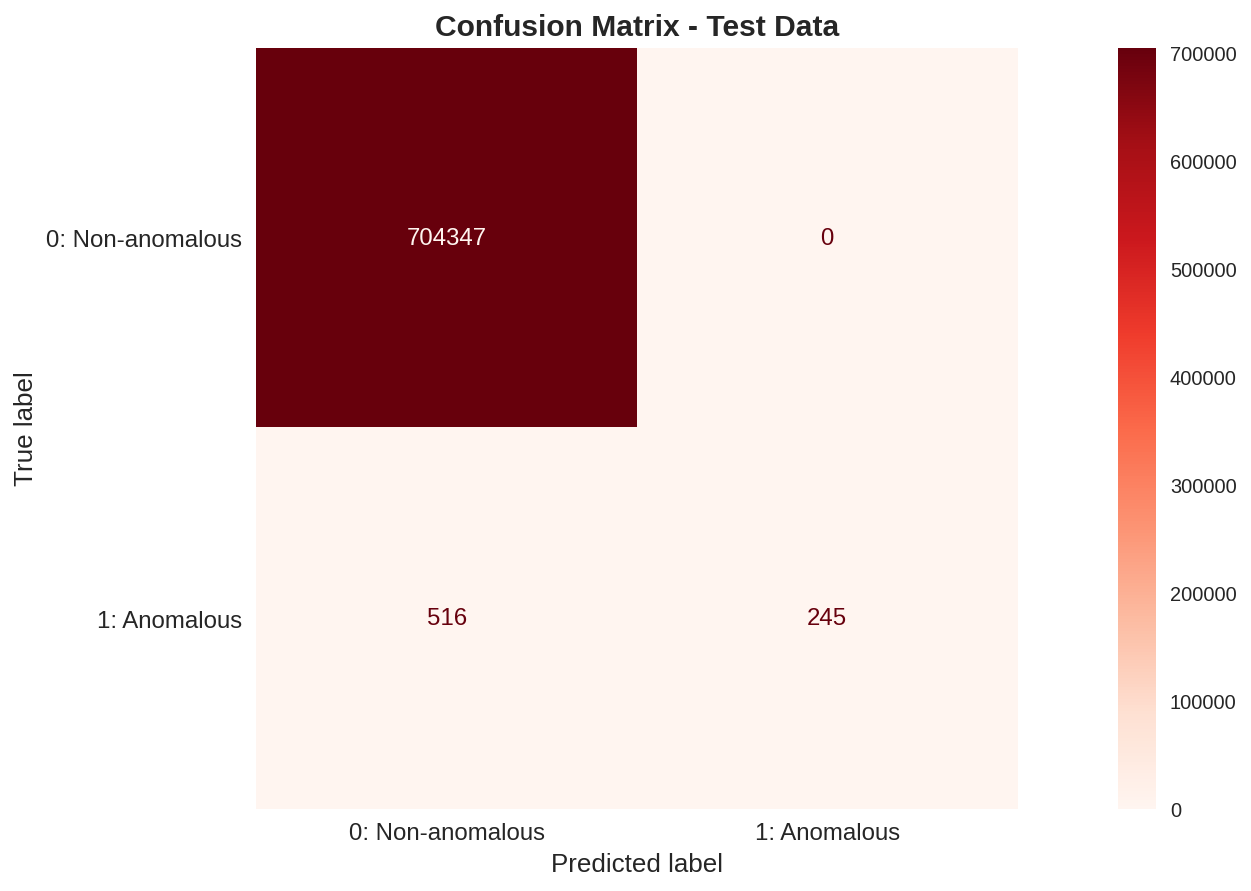

In [39]:
# Plot model confusion matrix
plot_confusion_matrix(rf_1_model, test_df_full)

**Remarks:**
- The random forest came close to, but couldn't ultimately beat, the more basic decision tree model, achieiving a 0.487 F1 score on anomalous transactions and correctly classifying 245 out of 761 anomalous transactions. 

<br>

# Model 6.2: **Random Forest Classifier**, Over and Undersampled, with Tuned Max Depth

Let's try another random forest, with the minority class still oversampled 10x, but let's also undersample the majority class 10x as well so it's even more balanced. There should be a distribution of about 90/10 majority to minority class observations now in the training data.

We'll keep the `entropy` impurity criterion that the grid search found to be optimal in the last model, but grid search over the maximum depth again and also the number of trees in the random forest.

In [40]:
train_df_full_resampled = spark_resample(df=train_df_full, oversample_fraction=10.0, undersample_fraction=0.1, 
                                         class_field='Anomalous', pos_class=1, shuffle=True, random_state=42)

# Drop Weight column
train_df_full_resampled = train_df_full_resampled.drop('Weight')
# Print shape of resampled dataframe
print(f"train_df_full_resampled:  {train_df_full_resampled.count():,} Rows, {len(train_df_full_resampled.columns)} Columns")
# Display value counts for 'Label' column (classification target) of resampled dataframe
resampled_class_counts = train_df_full_resampled.groupBy('Anomalous').count()\
                         .withColumn('percent', F.col('count')/train_df_full_resampled.count())

resampled_class_counts.show(truncate=10)

train_df_full_resampled:  517,567 Rows, 19 Columns
+---------+------+----------+
|Anomalous| count|   percent|
+---------+------+----------+
|        0|468328|0.90486...|
|        1| 49239|0.09513...|
+---------+------+----------+



In [41]:
rf_2 = RandomForestClassifier(
    featuresCol='scaled_features',
    labelCol='Anomalous', 
    impurity='entropy')

rf_2_stages = stages + [rf_2]

# Specify parameter grid
rf_2_grid = ParamGridBuilder()\
            .addGrid(rf_2.maxDepth, [4, 5, 6, 7])\
            .addGrid(rf_2.numTrees, [20, 30])\
            .build()

In [42]:
# Run grid search using grid_search function
if not os.path.isdir(drive_path + 'rf_2_model_full'):
    rf_2_model = grid_search(stages_with_classifier=rf_2_stages, 
                             train_df=train_df_full_resampled, 
                             model_grid=rf_2_grid, 
                             parallelism=5)

In [43]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'rf_2_model_full'):
    rf_2_model.save(drive_path + 'rf_2_model_full')
else:
    rf_2_model = TrainValidationSplitModel.load(drive_path + 'rf_2_model_full')
    print(rf_2_grid[np.argmax(rf_2_model.validationMetrics)])

{Param(parent='RandomForestClassifier_748140e5ee58', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7, Param(parent='RandomForestClassifier_748140e5ee58', name='numTrees', doc='Number of trees to train (>= 1).'): 20}


In [44]:
# Print model scores
score_model(rf_2_model, train_df_full_resampled, test_df_full)

RandomForestClassificationModel
------------------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.946     1.000     0.972    468328
    1: Anomalous      1.000     0.460     0.630     49239

        accuracy                          0.949    517567
       macro avg      0.973     0.730     0.801    517567
    weighted avg      0.951     0.949     0.940    517567

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     0.980     0.989    704347
    1: Anomalous      0.023     0.452     0.044       761

        accuracy                          0.979    705108
       macro avg      0.511     0.716     0.517    705108
    weighted avg      0.998     0.979     0.988    705108



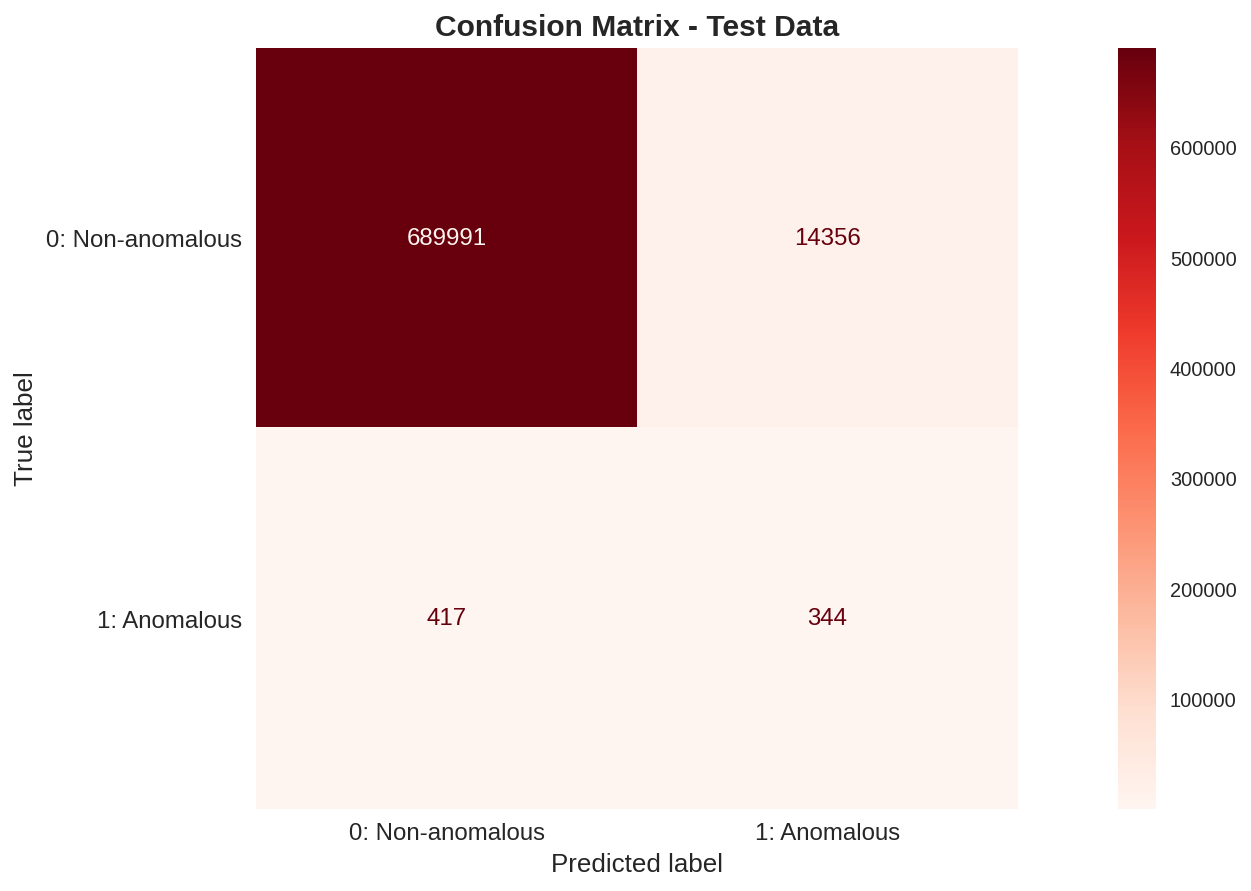

In [45]:
# Plot model confusion matrix
plot_confusion_matrix(rf_2_model, test_df_full)

**Remarks:**
- It looks like the random forest was able to boost the recall score to 0.452, but, again, at a very high cost in terms of reduced precision on the positive class, which ultimately drags down the F1 score. While performing much better than the GBT model, it's nowhere near the previous decision tree model, at least in terms of the F1 score.

<br>

# Model 6.3: **Random Forest** Classifier, Weighted, with Tuned Max Depth

Let's try one more random forest model, but this time we'll heavily overweight the minority class 20x using the `set_weight_col` function - no resampling. We'll again tune the maximum depth of the trees. We'll also set a new `seed` in the `grid_search` function because - why not? With so few anomalous transactions, the draw of the sample could make a difference.

In [46]:
train_df_full = set_weight_col(train_df_full, label_col='Anomalous', pos_class_weight=20.0, neg_class_weight=1.0)
# Preview Weight column
cols_to_show = ['Anomalous', 'Weight']
train_df_full.select(cols_to_show).where(train_df_full.Anomalous == 0).show(1, truncate=False, vertical=True)
train_df_full.select(cols_to_show).where(train_df_full.Anomalous == 1).show(1, truncate=False, vertical=True)

-RECORD 0--------
 Anomalous | 0   
 Weight    | 1.0 
only showing top 1 row

-RECORD 0---------
 Anomalous | 1    
 Weight    | 20.0 
only showing top 1 row



In [47]:
rf_3 = RandomForestClassifier(
    featuresCol='scaled_features',
    labelCol='Anomalous', 
    weightCol='Weight', 
    impurity='entropy')

rf_3_stages = stages + [rf_3]

# Specify parameter grid
rf_3_grid = ParamGridBuilder()\
            .addGrid(rf_3.maxDepth, [4, 5, 6, 7])\
            .build()

In [48]:
# Run grid search using grid_search function
if not os.path.isdir(drive_path + 'rf_3_model_full'):
    rf_3_model = grid_search(stages_with_classifier=rf_3_stages, 
                             train_df=train_df_full, 
                             model_grid=rf_3_grid, 
                             parallelism=4, 
                             seed=7)

In [49]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'rf_3_model_full'):
    rf_3_model.save(drive_path + 'rf_3_model_full')
else:
    rf_3_model = TrainValidationSplitModel.load(drive_path + 'rf_3_model_full')
    print(rf_3_grid[np.argmax(rf_3_model.validationMetrics)])

{Param(parent='RandomForestClassifier_b054c27078ef', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 6}


In [50]:
# Print model scores
score_model(rf_3_model, train_df_full, test_df_full)

RandomForestClassificationModel
------------------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000   4686825
    1: Anomalous      1.000     0.460     0.630      4900

        accuracy                          0.999   4691725
       macro avg      1.000     0.730     0.815   4691725
    weighted avg      0.999     0.999     0.999   4691725

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     0.992     0.996    704347
    1: Anomalous      0.055     0.440     0.097       761

        accuracy                          0.991    705108
       macro avg      0.527     0.716     0.546    705108
    weighted avg      0.998     0.991     0.995    705108



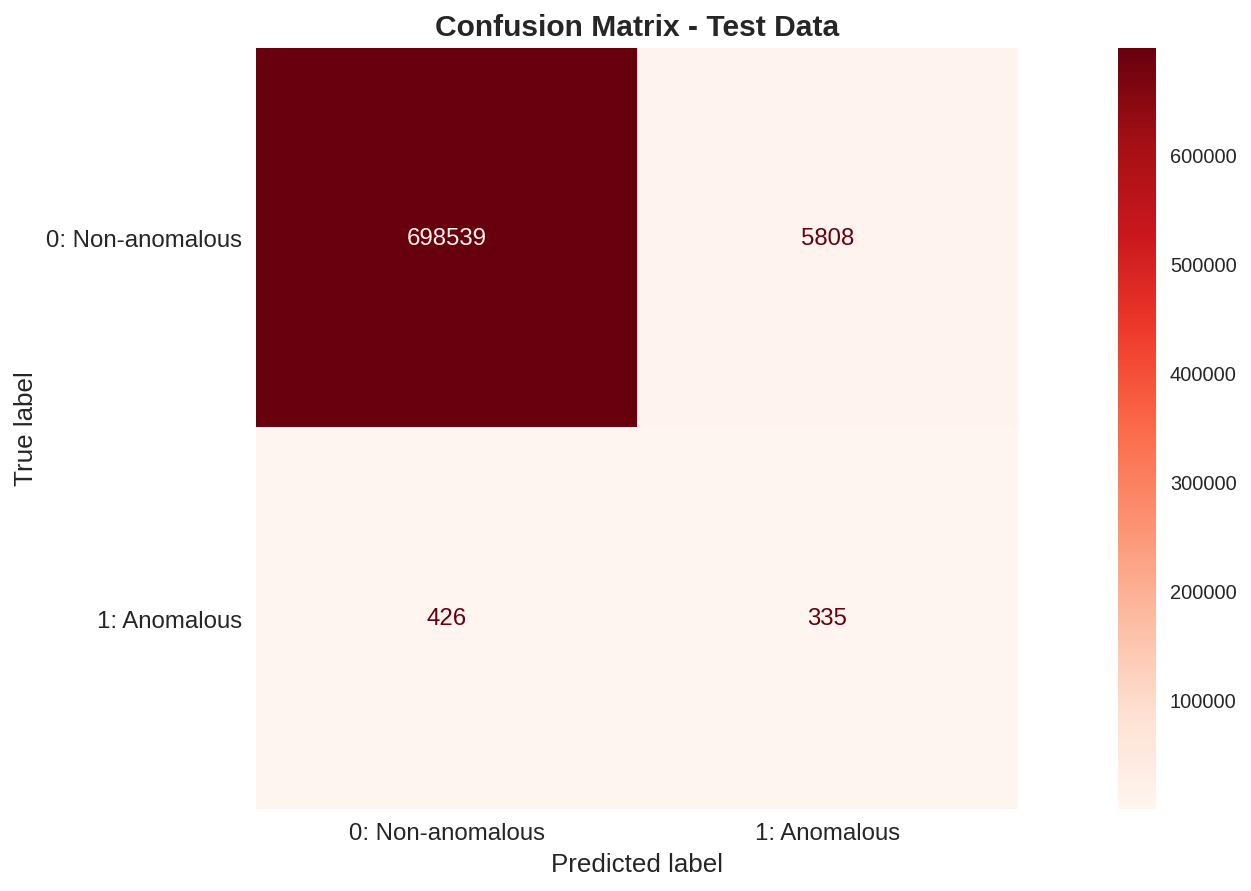

In [51]:
# Plot model confusion matrix
plot_confusion_matrix(rf_3_model, test_df_full)

**Remarks:**
- We got quite significant improvement with this random forest model in terms of improved precision in the minority class, but again, because the dataset is so imbalanced the F1 score is still overall far worse than the decision tree model with perfect precision.
- Let's move on to our final model:  a multilayer perceptron classifier.

<br>

# Model 7.1: **Multilayer Perceptron Classifier**, Undersampled

For our first multilayer perceptron (aka neural network) classifier, we'll use the unweighted, undersampled full dataset and go with a relatively middle-of-the-road one hidden layer with 30 nodes (to save time we won't grid search over this model).

In [52]:
train_df_full_resampled = spark_resample(df=train_df_full, oversample_fraction=1.0, undersample_fraction=0.1, 
                                         class_field='Anomalous', pos_class=1, shuffle=True, random_state=7)

# Drop Weight column
train_df_full_resampled = train_df_full_resampled.drop('Weight')
# Print shape of resampled dataframe
print(f"train_df_full_resampled:  {train_df_full_resampled.count():,} Rows, {len(train_df_full_resampled.columns)} Columns")
# Display value counts for 'Label' column (classification target) of resampled dataframe
resampled_class_counts = train_df_full_resampled.groupBy('Anomalous').count()\
                         .withColumn('percent', F.col('count')/train_df_full_resampled.count())

resampled_class_counts.show(truncate=10)

train_df_full_resampled:  474,129 Rows, 19 Columns
+---------+------+----------+
|Anomalous| count|   percent|
+---------+------+----------+
|        0|469229|0.98966...|
|        1|  4900|0.01033...|
+---------+------+----------+



In [53]:
# Set classifier hyperparameters
mlp_1 = MultilayerPerceptronClassifier(
    featuresCol='scaled_features',
    labelCol='Anomalous', 
    layers=[91, 30, 2])

In [54]:
# Assign to pipeline
mlp_1_pipeline = Pipeline(stages=stages + [mlp_1])

# Fit to training data
if not os.path.isdir(drive_path + 'mlp_1_model_full'):
    mlp_1_model = mlp_1_pipeline.fit(train_df_full_resampled)

In [55]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'mlp_1_model_full'):
    mlp_1_model.save(drive_path + 'mlp_1_model_full')
else:
    mlp_1_model = PipelineModel.load(drive_path + 'mlp_1_model_full')

In [56]:
# Print model scores
score_model(mlp_1_model, train_df_full_resampled, test_df_full)

MultilayerPerceptronClassificationModel
--------------------------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.997     0.999     0.998    469229
    1: Anomalous      0.928     0.669     0.777      4900

        accuracy                          0.996    474129
       macro avg      0.962     0.834     0.888    474129
    weighted avg      0.996     0.996     0.996    474129

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      1.000     0.957     0.978    704347
    1: Anomalous      0.017     0.669     0.032       761

        accuracy                          0.957    705108
       macro avg      0.508     0.813     0.505    705108
    weighted avg      0.999     0.957     0.977    705108



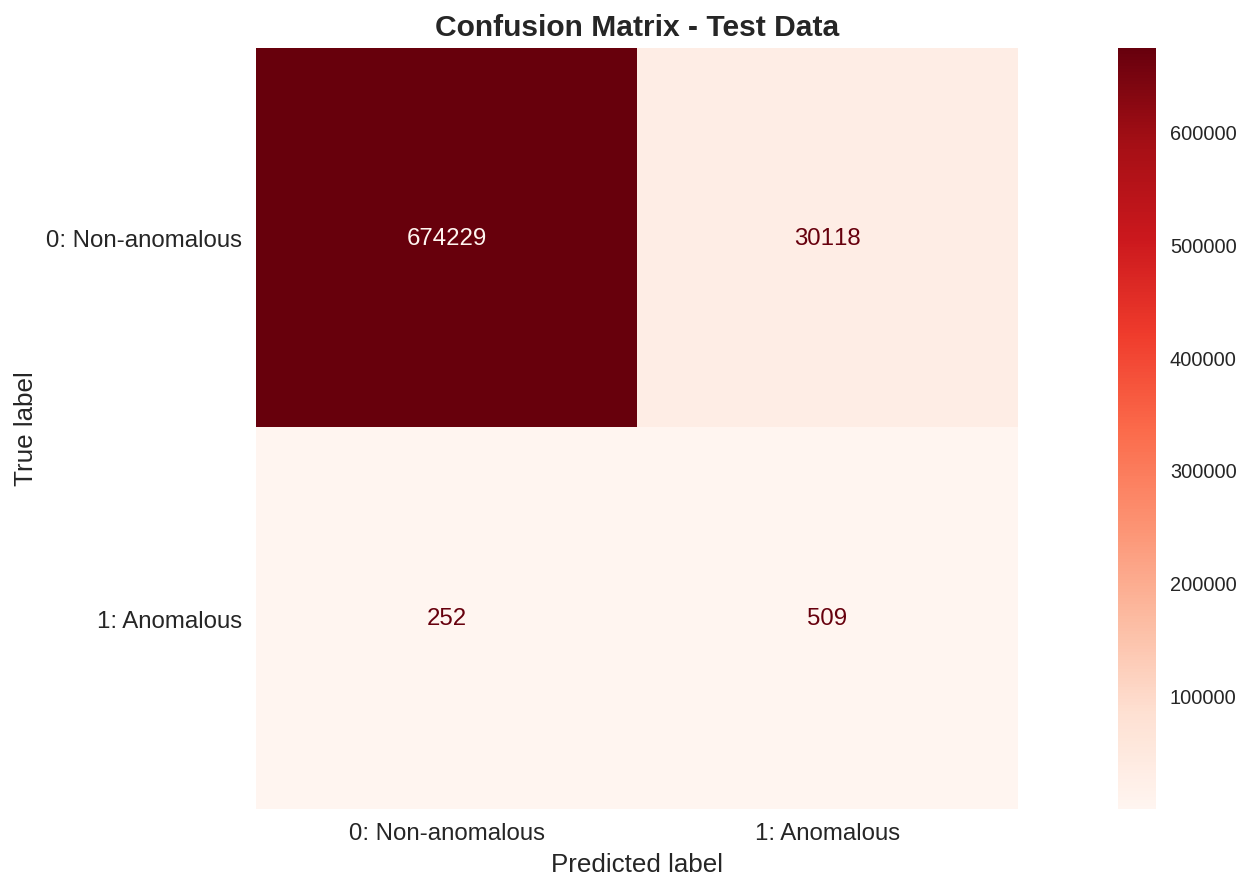

In [57]:
# Plot model confusion matrix
plot_confusion_matrix(mlp_1_model, test_df_full)

**Remarks:**
- Well we got a new high on positive class recall, but also a new high on positive class false positive rate which is dragging down the F1 score to a measly 0.032. It looks like the model is majorly overfitting, since the model did quite well on the training data with an F1 score of 0.779.

<br>

# Model 7.2: **Multilayer Perceptron Classifier** with Simpler Neural Network

Let's try another MLP, but with more negative class observations this time and a simpler neural network in terms of number of nodes, but more layers, since our previous MLP was overfitting so heavily.

In [58]:
train_df_full_resampled = spark_resample(df=train_df_full, oversample_fraction=1.0, undersample_fraction=0.5, 
                                         class_field='Anomalous', pos_class=1, shuffle=False, random_state=7)

# Drop Weight column
train_df_full_resampled = train_df_full_resampled.drop('Weight')
# Print shape of resampled dataframe
print(f"train_df_full_resampled:  {train_df_full_resampled.count():,} Rows, {len(train_df_full_resampled.columns)} Columns")
# Display value counts for 'Label' column (classification target) of resampled dataframe
resampled_class_counts = train_df_full_resampled.groupBy('Anomalous').count()\
                         .withColumn('percent', F.col('count')/train_df_full_resampled.count())

resampled_class_counts.show(truncate=10)

train_df_full_resampled:  2,347,148 Rows, 19 Columns
+---------+-------+----------+
|Anomalous|  count|   percent|
+---------+-------+----------+
|        0|2342248|0.99791...|
|        1|   4900|0.00208...|
+---------+-------+----------+



In [59]:
# Set classifier hyperparameters
mlp_2 = MultilayerPerceptronClassifier(
    featuresCol='scaled_features',
    labelCol='Anomalous', 
    layers=[91, 15, 12, 8, 5, 2])

In [60]:
# Assign to pipeline
mlp_2_pipeline = Pipeline(stages=stages + [mlp_2])

# Fit to training data
if not os.path.isdir(drive_path + 'mlp_2_model_full'):
    mlp_2_model = mlp_2_pipeline.fit(train_df_full_resampled)

In [61]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'mlp_2_model_full'):
    mlp_2_model.save(drive_path + 'mlp_2_model_full')
else:
    mlp_2_model = PipelineModel.load(drive_path + 'mlp_2_model_full')

In [62]:
# Print model scores
score_model(mlp_2_model, train_df_full_resampled, test_df_full)

MultilayerPerceptronClassificationModel
--------------------------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     0.999   2342248
    1: Anomalous      0.963     0.486     0.646      4900

        accuracy                          0.999   2347148
       macro avg      0.981     0.743     0.823   2347148
    weighted avg      0.999     0.999     0.999   2347148

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     0.999     0.999    704347
    1: Anomalous      0.443     0.465     0.454       761

        accuracy                          0.999    705108
       macro avg      0.721     0.732     0.726    705108
    weighted avg      0.999     0.999     0.999    705108



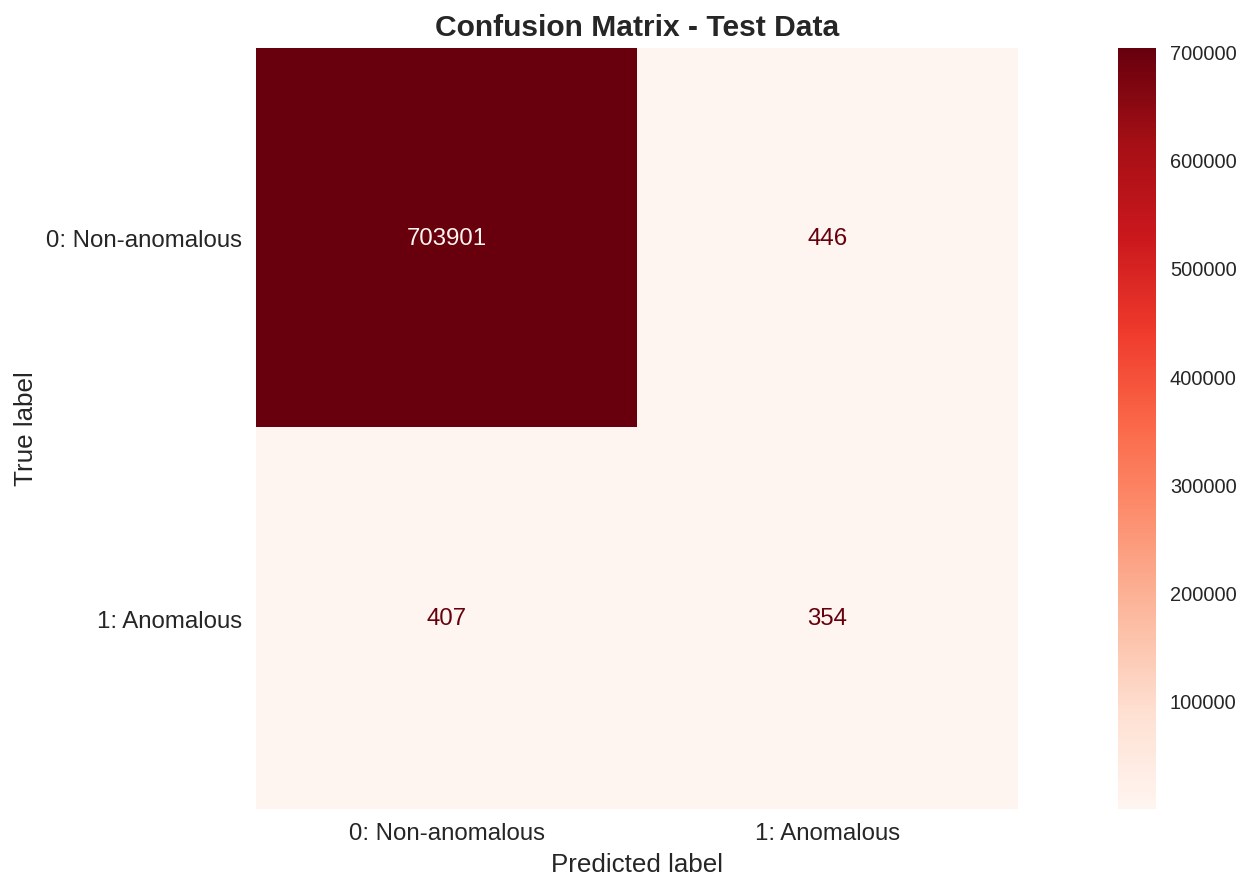

In [63]:
# Plot model confusion matrix
plot_confusion_matrix(mlp_2_model, test_df_full)

**Remarks:**
- Interesting! We seem to be on to something here. Our recall is better than our best overall model so far, with only a very small handful of false positives. Let's take this model and ramp up what we changed: even more observations and layers.

<br>

# Model 7.3: **Multilayer Perceptron Classifier** with More Hidden Layers

We got some very promising results on our last MLP model after using lots of hidden layers with a small number of decreasing nodes in each. Let's continue down that road and see if we can get more improvement with the full dataset with even more hidden layers.

In [64]:
# Set classifier hyperparameters
mlp_3 = MultilayerPerceptronClassifier(
    featuresCol='scaled_features',
    labelCol='Anomalous', 
    layers=[91, 15, 12, 10, 8, 7, 5, 2])

In [65]:
# Assign to pipeline
mlp_3_pipeline = Pipeline(stages=stages + [mlp_3])

# Fit to training data
if not os.path.isdir(drive_path + 'mlp_3_model_full'):
    mlp_3_model = mlp_3_pipeline.fit(train_df_full_resampled)

In [66]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'mlp_3_model_full'):
    mlp_3_model.save(drive_path + 'mlp_3_model_full')
else:
    mlp_3_model = PipelineModel.load(drive_path + 'mlp_3_model_full')

In [67]:
# Print model scores
score_model(mlp_3_model, train_df_full_resampled, test_df_full)

MultilayerPerceptronClassificationModel
--------------------------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     0.999   2342248
    1: Anomalous      0.972     0.422     0.589      4900

        accuracy                          0.999   2347148
       macro avg      0.985     0.711     0.794   2347148
    weighted avg      0.999     0.999     0.999   2347148

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000    704347
    1: Anomalous      0.711     0.407     0.518       761

        accuracy                          0.999    705108
       macro avg      0.855     0.704     0.759    705108
    weighted avg      0.999     0.999     0.999    705108



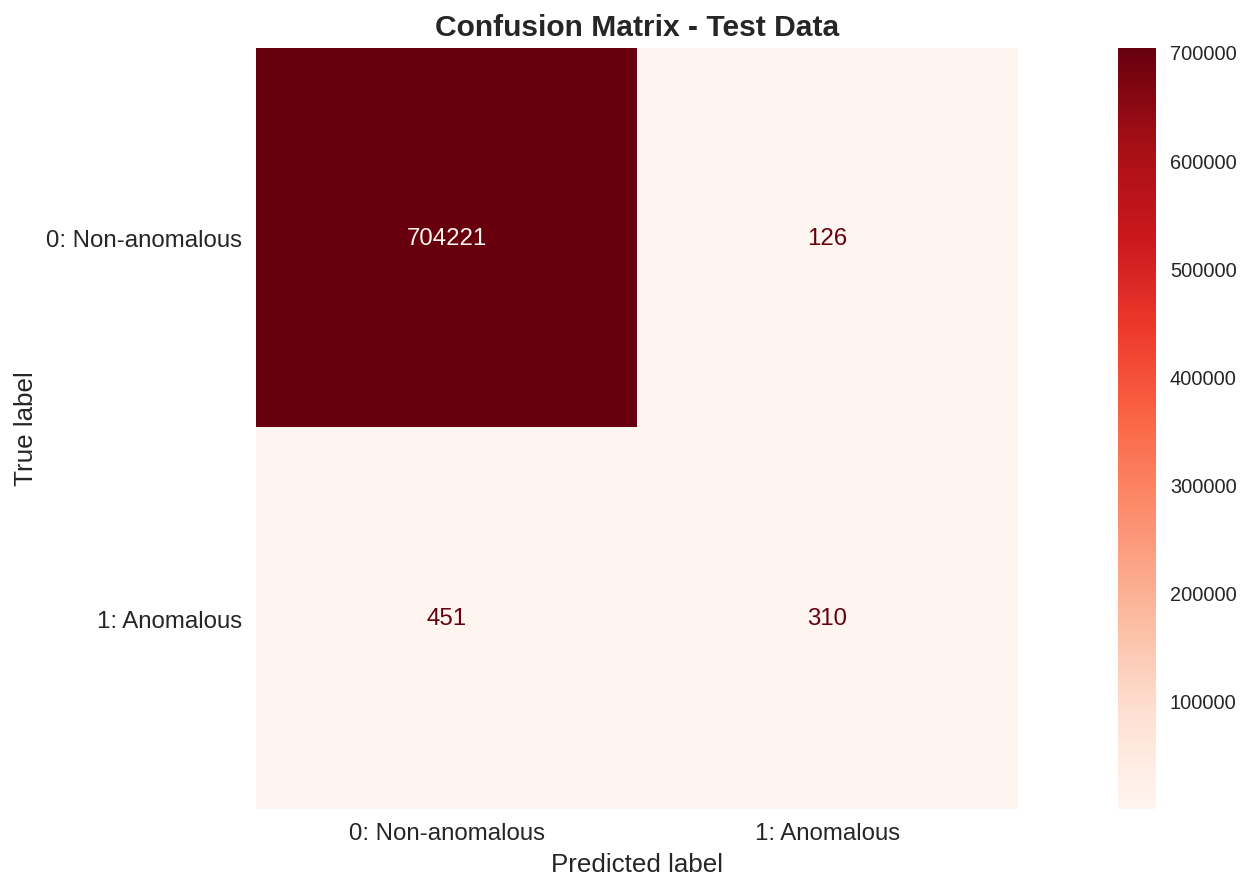

In [68]:
# Plot model confusion matrix
plot_confusion_matrix(mlp_3_model, test_df_full)

**Remarks:**
- Our F1 score improved again! We're getting really close to our best model, but our recall is also approaching the best decision tree model now while we've still got a good deal of false positives. Let's try a bit more tuning to see if we can beat the decision tree.

<br>

# Model 7.4: **Multilayer Perceptron Classifier** with Even More Hidden Layers

Let's try even more hidden layers with the same dataframe to see if we can keep improving the F1 score.

In [69]:
# Set classifier hyperparameters
mlp_4 = MultilayerPerceptronClassifier(
    featuresCol='scaled_features',
    labelCol='Anomalous', 
    layers=[91, 20, 15, 13, 12, 10, 8, 7, 5, 2])

In [70]:
# Assign to pipeline
mlp_4_pipeline = Pipeline(stages=stages + [mlp_4])

# Fit to training data
if not os.path.isdir(drive_path + 'mlp_4_model_full'):
    mlp_4_model = mlp_4_pipeline.fit(train_df_full_resampled)

In [71]:
# Save model, or upload if already saved
if not os.path.isdir(drive_path + 'mlp_4_model_full'):
    mlp_4_model.save(drive_path + 'mlp_4_model_full')
else:
    mlp_4_model = PipelineModel.load(drive_path + 'mlp_4_model_full')

In [72]:
# Print model scores
score_model(mlp_4_model, train_df_full_resampled, test_df_full)

MultilayerPerceptronClassificationModel
--------------------------------------- 

Training data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     0.999   2342248
    1: Anomalous      0.973     0.428     0.594      4900

        accuracy                          0.999   2347148
       macro avg      0.986     0.714     0.797   2347148
    weighted avg      0.999     0.999     0.999   2347148

------------------------------------------------------------ 

Testing data:

                  precision    recall  f1-score   support

0: Non-anomalous      0.999     1.000     1.000    704347
    1: Anomalous      0.934     0.407     0.567       761

        accuracy                          0.999    705108
       macro avg      0.967     0.704     0.783    705108
    weighted avg      0.999     0.999     0.999    705108



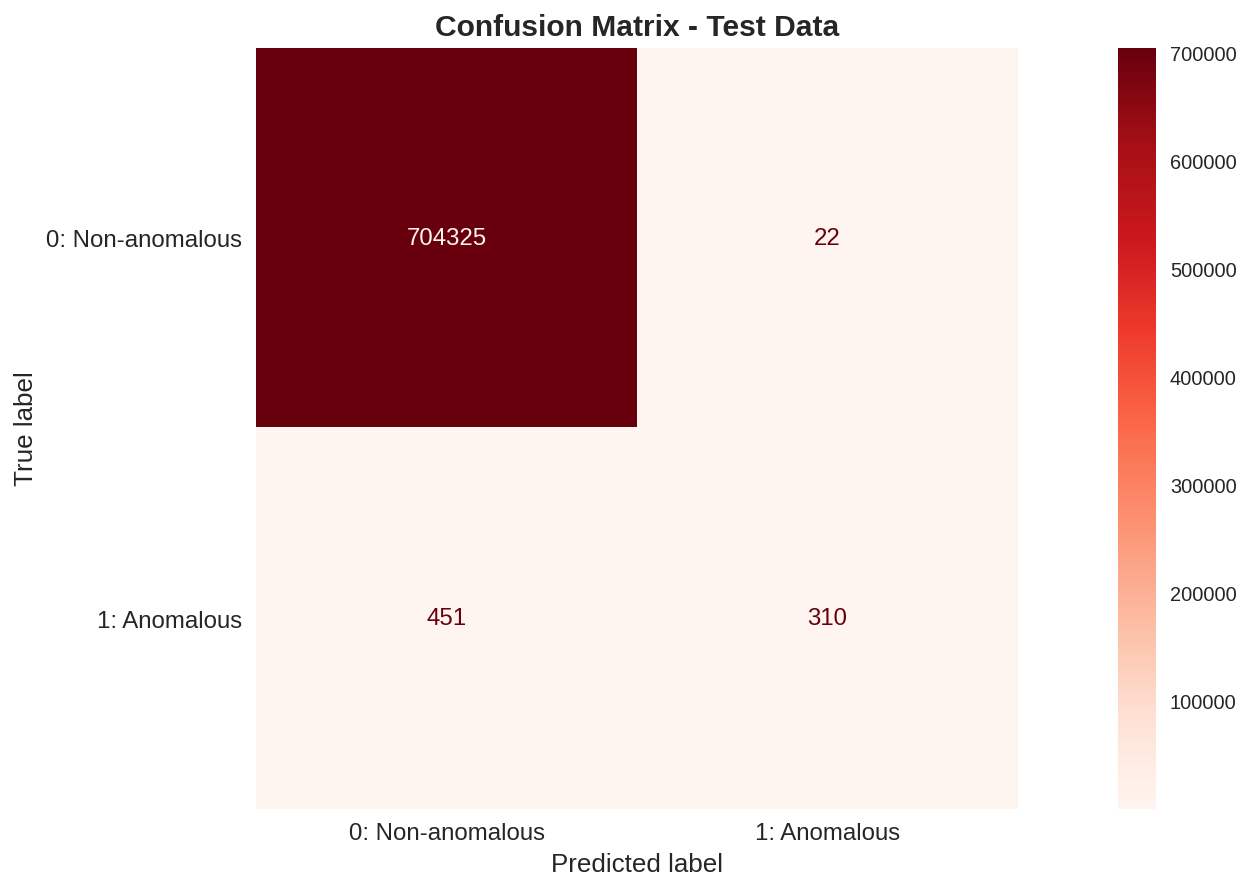

In [73]:
# Plot model confusion matrix
plot_confusion_matrix(mlp_4_model, test_df_full)

**Remarks:**
- New high score! We didn't beat the previous best F1 score by much (0.017), but we got a new best. We correctly classified 310/761 anomalous transactions and had only 22 false positives.

<br>

# Results and Evaluation

## Dataframe of compiled model results - F1 scores

Training and testing F1 scores for each model are compiled, along with testing precision and recall scores. Class weights and resampling method for each model are also included. Models are sorted by descending test F1 scores on anomalous transactions, with training F1 scores on anomalous transactions breaking the tie.

In [74]:
columns = ['Model', 'Training F1 Score', 'Test F1 Score', 'Test Precision', 'Test Recall', 'Class Weights', 'Resampling']

models = ['Model 0: Baseline Logistic Regression', 'Model 1.1: Logistic Regression 1', 'Model 1.2: Logistic Regression 2', 
          'Model 2.1: SVC 1', 'Model 2.2: SVC 2', 'Model 3.1: Naive Bayes Classifier 1', 'Model 4.1: Decision Tree Classifier 1', 
          'Model 5.1: GBT Classifier 1', 'Model 5.2: GBT Classifier 2', 'Model 4.2: Decision Tree Classifier 2', 
          'Model 6.1: Random Forest Classifier 1', 'Model 6.2: Random Forest Classifier 2', 'Model 6.3: Random Forest Classifier 3', 
          'Model 7.1: Multilayer Perceptron Classifier 1', 'Model 7.2: Multilayer Perceptron Classifier 2', 
          'Model 7.3: Multilayer Perceptron Classifier 3', 'Model 7.4: Multilayer Perceptron Classifier 4']

train_f1_scores = [0.482, 0.314, 0.314, 0.314, 0.314, 0.031, 0.577, 0.671, 0.515, 0.578, 0.476, 0.630, 0.630, 0.779, 0.646, 0.589, 0.594]
test_f1_scores = [0.019, 0.265, 0.265, 0.265, 0.265, 0.026, 0.555, 0.019, 0.015, 0.555, 0.487, 0.044, 0.097, 0.032, 0.454, 0.518, 0.567]
test_precision_scores = [0.010, 1.000, 1.000, 1.000, 1.000, 0.014, 1.000, 0.010, 0.008, 1.000, 1.000, 0.023, 0.055, 0.017, 0.443, 0.711, 0.934]
test_recall_scores = [0.294, 0.152, 0.152,0.152, 0.152, 0.180, 0.384, 0.562, 0.321, 0.384, 0.322, 0.452, 0.440, 0.669, 0.465, 0.407, 0.407]
class_weights = ['Unweighted', 'Unweighted', 'Unweighted', 'Pos: 1.0, Neg: 0.1', 'Pos: 1.0, Neg: 0.5', 'Pos: 1.0, Neg: 0.01', 'Pos: 1.0, Neg: 0.1', 
                 'Pos: 1.0, Neg: 0.1', 'Unweighted', 'Unweighted', 'Unweighted', 'Unweighted', 'Unweighted', 'Unweighted', 'Unweighted', 
                 'Unweighted', 'Unweighted']
resampling = ['Unsampled', 'Unsampled', 'Unsampled', 'Unsampled', 'Unsampled', 'Unsampled', 'Unsampled', 'Unsampled', 'Unsampled', 'Oversampled 10x', 
              'Oversampled 10x', 'Oversampled 10x, Undersampled 10x', 'Oversampled 20x', 'Undersampled 10x', 'Undersampled 2x', 'Undersampled 2x', 
              'Undersampled 2x']

compiled_scores = list(zip(models, train_f1_scores, test_f1_scores, test_precision_scores, test_recall_scores, class_weights, resampling))

compiled_f1_scores_df = pd.DataFrame(compiled_scores, columns=columns)
compiled_f1_scores_df.sort_values(by=['Test F1 Score', 'Training F1 Score'], ascending=False)

,Model,Training F1 Score,Test F1 Score,Test Precision,Test Recall,Class Weights,Resampling
16,Model 7.4: Multilayer Perceptron Classifier 4,0.594,0.567,0.934,0.407,Unweighted,Undersampled 2x
9,Model 4.2: Decision Tree Classifier 2,0.578,0.555,1.000,0.384,Unweighted,Oversampled 10x
6,Model 4.1: Decision Tree Classifier 1,0.577,0.555,1.000,0.384,"Pos: 1.0, Neg: 0.1",Unsampled
15,Model 7.3: Multilayer Perceptron Classifier 3,0.589,0.518,0.711,0.407,Unweighted,Undersampled 2x
10,Model 6.1: Random Forest Classifier 1,0.476,0.487,1.000,0.322,Unweighted,Oversampled 10x
14,Model 7.2: Multilayer Perceptron Classifier 2,0.646,0.454,0.443,0.465,Unweighted,Undersampled 2x
1,Model 1.1: Logistic Regression 1,0.314,0.265,1.000,0.152,Unweighted,Unsampled
2,Model 1.2: Logistic Regression 2,0.314,0.265,1.000,0.152,Unweighted,Unsampled
3,Model 2.1: SVC 1,0.314,0.265,1.000,0.152,"Pos: 1.0, Neg: 0.1",Unsampled
4,Model 2.2: SVC 2,0.314,0.265,1.000,0.152,"Pos: 1.0, Neg: 0.5",Unsampled


<br>

## Compile and visualize feature importances

Here we visualize feature importances for the best performing random forest model. We use the random forest model, even though it wasn't the best performing model overall, because as of now it appears to be the only classifier in PySpark that has functionality for extracting feature importances.

In [75]:
# Assign random forest model vector assembler to variable to extract feature names
va = rf_1_model.bestModel.stages[-3]
# Assign random forest classifier to variable
random_forest = rf_1_model.bestModel.stages[-1]

# Print high-level classifier parameters
display(random_forest)
print()
# Get feature importances
feature_importances = list(zip(va.getInputCols(), random_forest.featureImportances))

RandomForestClassificationModel: uid=RandomForestClassifier_7ad0f393a278, numTrees=20, numClasses=2, numFeatures=91

In [76]:
columns = ['Feature', 'Importance']
feature_importances_df = pd.DataFrame(feature_importances, columns=columns).sort_values(by='Importance', ascending=False)
feature_importances_df

,Feature,Importance
8,Flagged,0.013399
3,BeneficiaryCountry_index_ohe,0.013126
9,OrderingCountryFreq,0.012029
13,SenderCurrencyFreq,0.011976
14,SenderCurrencyAmtAvg,0.010802
10,BeneficiaryCountryFreq,0.010369
16,ReceiverFreq,0.008728
1,InstructedCurrency_index_ohe,0.006837
12,SenderHourFreq,0.004918
5,FinalReceiver_index_ohe,0.004792


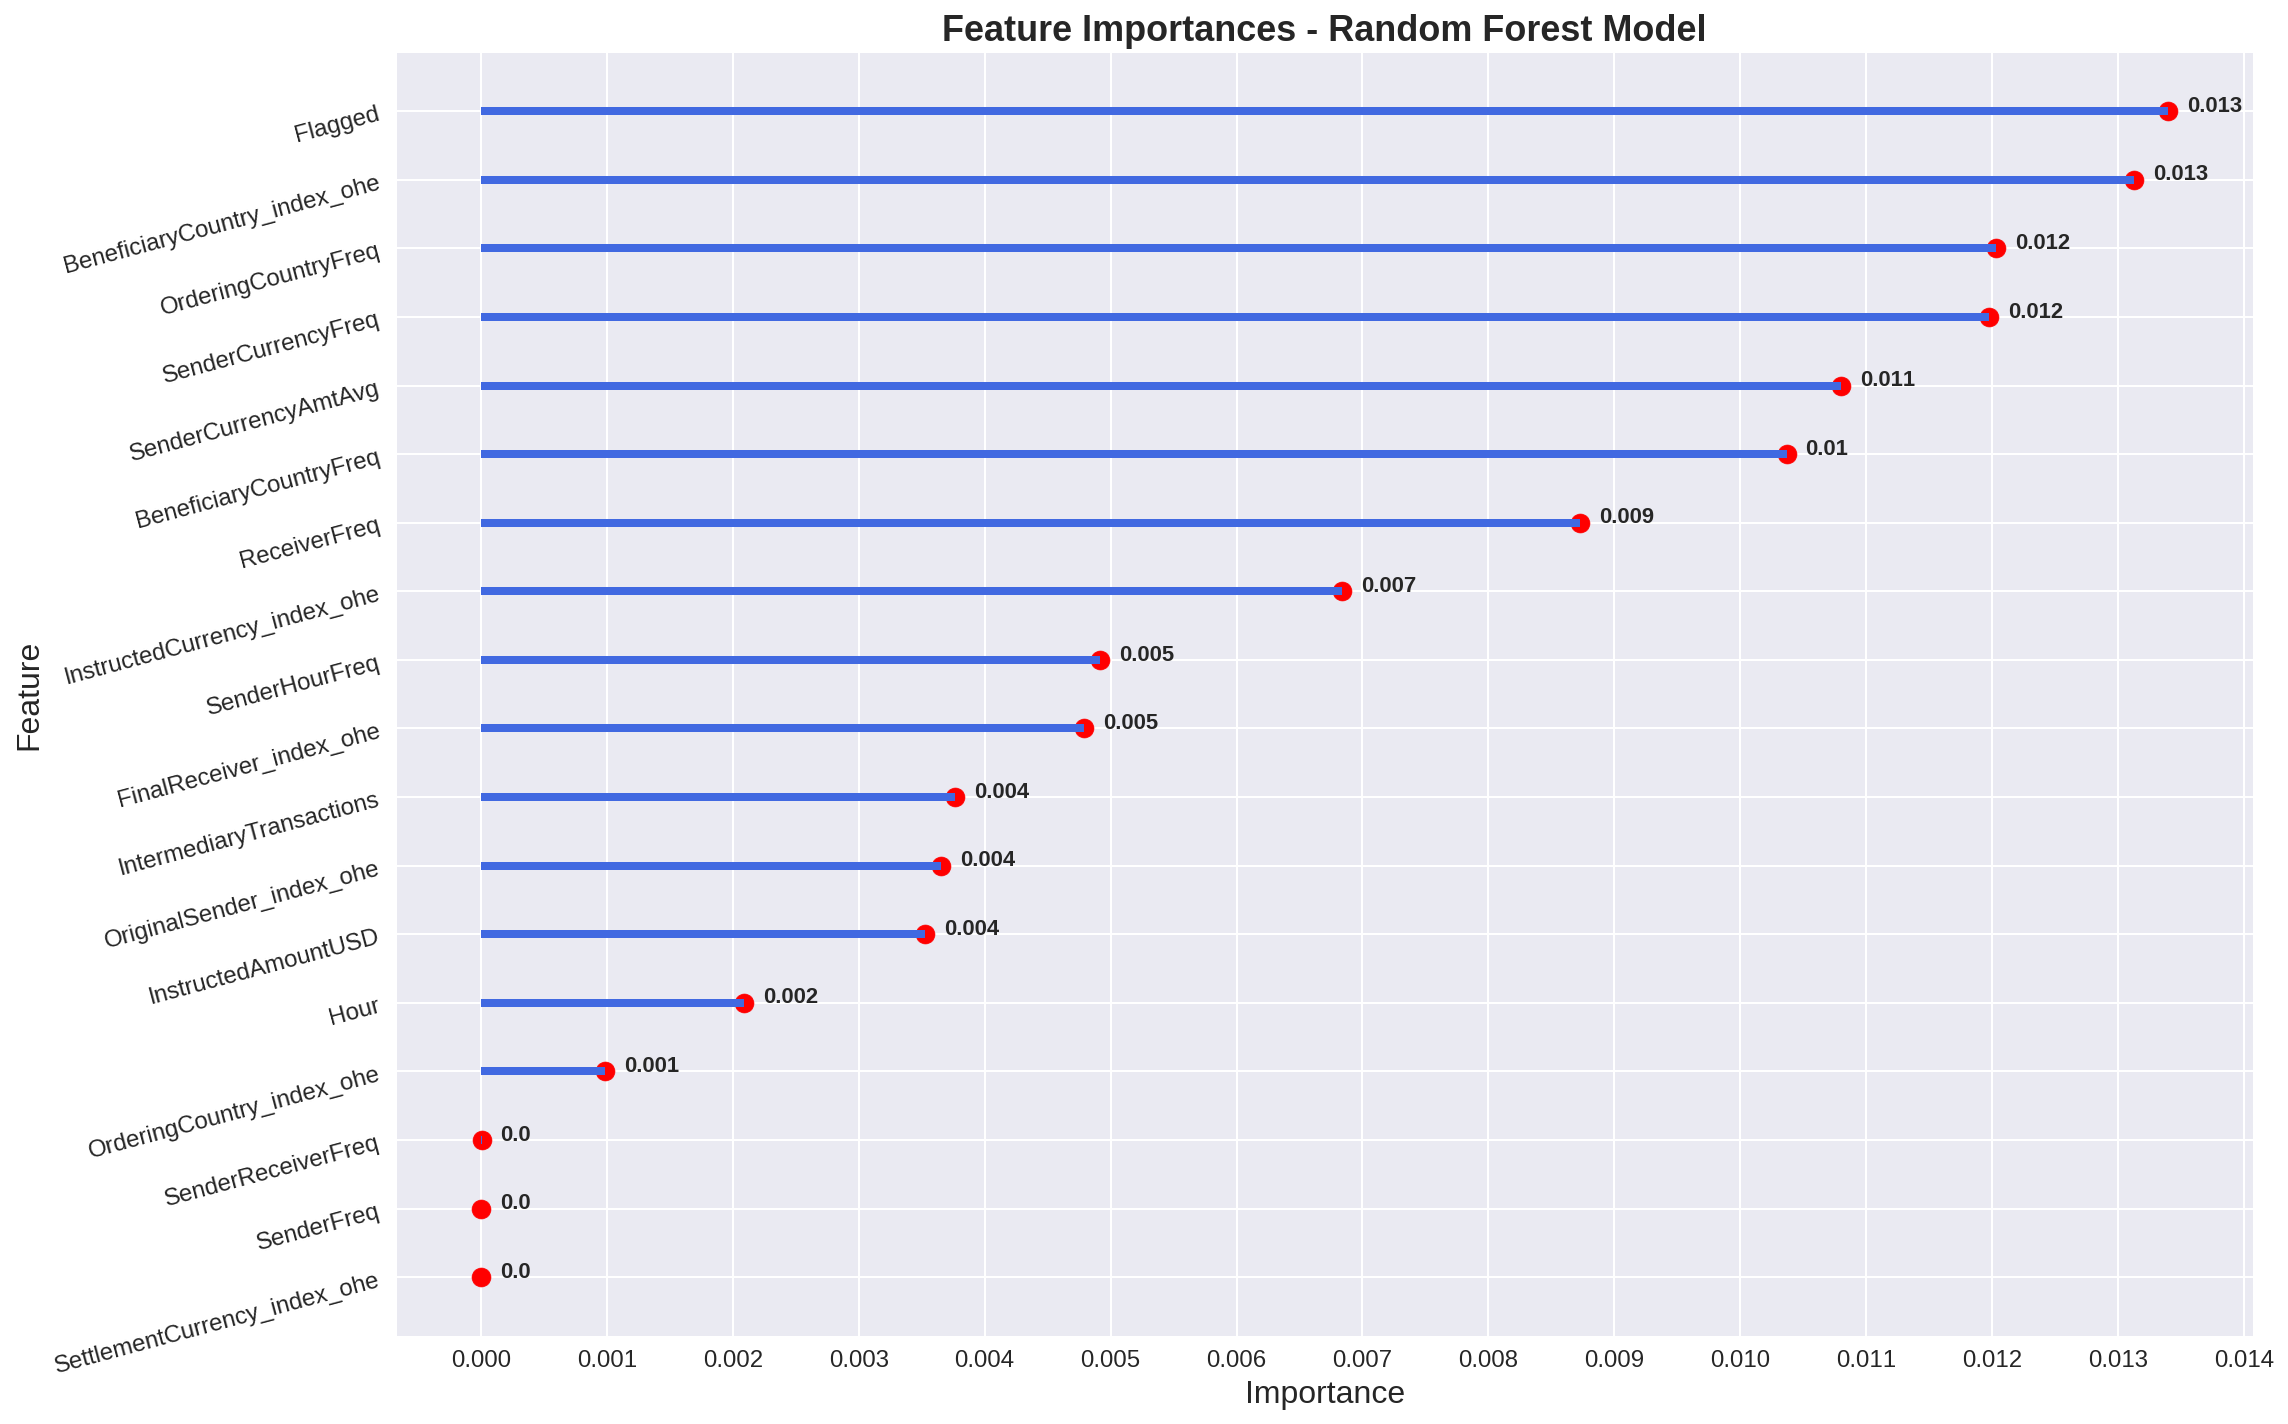

In [77]:
fig, ax = plt.subplots(figsize=(16, 10))

# Plot horizontal lines
plt.hlines(feature_importances_df['Feature'].iloc[::-1], linewidths=4, xmin=0, color='royalblue', 
           xmax=feature_importances_df['Importance'].iloc[::-1])

# Plot circles
plt.scatter(feature_importances_df['Importance'], feature_importances_df['Feature'],
            color='red', alpha=1, s=90)

# Annotate exact numerical values at end of lines
for idx, row in feature_importances_df.iterrows():
    ax.annotate(f"{round(row['Importance'], 3)}", (row['Importance'], row['Feature']), 
                weight='bold', fontsize=11, 
                xytext=(row['Importance'] + 0.00015, row['Feature'])) # offset annotate

plt.title('Feature Importances - Random Forest Model', fontsize=18, fontweight='bold')
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.yticks(fontsize=12, rotation=15)
ax.set_xticks(list(np.arange(0, .015, 0.001)))
plt.xticks(fontsize=12)
plt.tight_layout();

<br>

# Conclusions, Recommendations, and Next Steps

***Conclusions:***

- **Final model strengths and weaknesses:** Our highest scoring model, model 7.4 - multilayer perceptron (artifical neural network), achieved a test F1 score of 0.567, beating the previous best model, a decision tree, by 0.017. The model correctly classified approximately 41% of the anomalous transactions (recall) and had a positive predictive value (precision) of over 93%, meaning over 93% of its predictions of anomalous transactions are in fact anomalous. While correctly identifying less than half of the anomalous transactions may seem mediocre, given that the model essentially needs to find needles in a haystack (761 anomalous transactions out of over 705k) with near surgical precision, it is no small feat.<br>
<br>

- **After a certain point, it is difficult to increase recall without substantially reducing precision.** As we outlined in the business understanding section, because this dataset is so imbalanced, even a 1% loss in precision on the testing data means ~700 additional false positives, nearly the entire amount of true positives. This means that increasing recall tends to come at a heavy cost in terms of reduced precision and more false positives, which ultimately seriously degrades the value of the model.<br>
<br>

- **The most important features for the model include whether the account is flagged, the country of the beneficiary account, and the frequency of the country of the ordering entity.** Sender currency frequency and beneficiary country frequency round out the top five. It's not surprising that the `Flagged` feature was important, given that we saw it was perfectly correlated with anomalous transactions in the EDA section. The country of the beneficiary account is also a logical feature to contain a good deal of predictive value. Perhaps surprisingly, `SenderReceiverFreq` was a very poor predictor, at least for the random forest model. `SenderFreq` and `SettlementCurrency` also did not seem to contain much predictive value.<br>
<br>

***Recommendations and Use Cases:***
- **Use the models as a guide on where to focus investigatory resources.** The limited time and resources of investigators should be wisely spent so as to limit time chasing false leads or annoying law-abiding customers. A model which can identify truly anomalous/potentially illicit transactions has a lot of value in terms of providing a signpost for where stakeholders should focus their resources for maximum benefit.<br>
<br>

- **Improve precision scores before using one of the models with a higher recall but lower F1 score.** As we saw, some models had higher recall than the best perceptron or decision tree models, but came with much lower precision. These models may have potential given additional tuning, but as is they likely carry more downside than upside in terms of false positives and have the potantial to lead to time chasing dead ends.<br>
<br>

- **Non-linear models appear to outperform linear ones for this use case.** Many of our initial linear models suffered from overreliance on one or a few features, likely because they were the only ones with a clear linear correlation with the target variable. As we saw in the EDA section though, many of the features do not have a linear relationship with anomalous transactions. Better results will likely be achieved with models which can pick up on these more complex relationships, such as decision tree-based models and neural networks.<br>
<br>
 
***Next Steps and Remaining Questions:***
- **Obtain more positive class observations.** While synthetic adjustment to the dataset can be made to even out the class imbalance, such as over or undersampling, SMOTE, or adjusting class weights, the best option is almost always to obtain more observations of the minority class. The models could likely perform better if they have more data of the positive class to go off of.<br>
<br>
- **Experiment with synthetic minority oversampling technique (SMOTE).** SMOTE was not used as part of this project because it does not appear to be supported by PySpark at the time of writing. While we did oversample the minority class with some models, SMOTE may have done a better job preventing overfitting, as simple oversampling can tend to cause models to overfit to noise that happens to be present in the minority class observations.<br>
<br>
- **Why did the model fail to improve substantially after the inclusion of six additional categorical variables?** Despite the feature importances of the random forest model telling us that multiple one hot encoded features had high importance, the model barely budged in F1 score between the best numeric dataset model and the best full dataset model. Did the numeric features we engineered capture all or most of the signal in the categorical features? Or maybe some of the categorical features were indeed valuable, but others introduced noise into the model that drowned out the signal of the valuable predictors. Investigating this further could yield valuable insights.